In [53]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman
import itertools
from networkx.algorithms import community
import numpy as np
from collections import deque
from modularity_maximization import utils, _divide
print("nx version:",nx.__version__)

nx version: 2.6.3


In [54]:
!pip install python-modularity-maximization==0.0.1rc4

In [55]:
from modularity_maximization import partition
from modularity_maximization.utils import get_modularity

In [56]:
# import karate club graph
karate_gml = nx.read_gml("karate.gml", label = 'id')
assert nx.number_of_nodes(karate_gml) == 34
# import jazz graph
jazz_gml = nx.read_gml("jazz.gml")
# import dolphins graph
dolphins_gml = nx.read_gml("dolphins.gml")

In [57]:
graphs_list = [karate_gml, dolphins_gml, jazz_gml]
data = list()
for graph in graphs_list:
  d = [
        nx.number_of_nodes(graph),
        nx.number_of_edges(graph),
        nx.average_shortest_path_length(graph),
        nx.algorithms.cluster.average_clustering(graph),
  ]
  data.append(d)

df = pd.DataFrame(data, columns=["Nodes(n)","Edges(m)","Average Path Length(d)", "Average Clustering(C)",])
graph_names = ["Karate club", "Dolphins", "Jazz"]
df.insert(0, "Dataset",graph_names)
df

,Dataset,Nodes(n),Edges(m),Average Path Length(d),Average Clustering(C)
0,Karate club,34,78,2.408200,0.570638
1,Dolphins,62,159,3.356954,0.258958
2,Jazz,198,2742,0.796262,0.308725


In [ ]:
def girvan_newman (G):
  G = G.copy ()

  def find_best_edge (G0):
    eb = nx.edge_betweenness_centrality(G0) 
    edges = eb.keys()
    return max(edges, key=lambda e: eb[e])

  removed_edges = []
  while nx.number_connected_components (G) == 1:
    u, v = find_best_edge(G)
    G.remove_edge (u, v)
    removed_edges.append((u, v))

  return list (nx.connected_components(G)), removed_edges

In [63]:
new_G = girvan_newman(dolphins_gml)
communities = tuple(sorted(c) for c in next(new_G))

dolphins = nx.read_gml('dolphins.gml')
k = 4
comp = girvan_newman(dolphins)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
comm_dicts = []
for communities in limited:
    print(tuple(sorted(c) for c in communities))
    comm_dicts.append(tuple(sorted(c) for c in communities))

(['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'PL', 'Patchback', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN9', 'SN96', 'Scabs', 'Shmuddel', 'Stripes', 'TR120', 'TR77', 'TR88', 'TR99', 'TSN103', 'TSN83', 'Thumper', 'Topless', 'Trigger', 'Vau', 'Whitetip', 'Zap', 'Zipfel'], ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN89', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig'])
(['Beak', 'Bumper', 'CCL', 'Cross', 'Double', 'Fish', 'Five', 'Fork', 'Grin', 'Haecksel', 'Hook', 'Jonah', 'Kringel', 'MN105', 'MN60', 'MN83', 'Oscar', 'PL', 'Patchback', 'SMN5', 'SN100', 'SN4', 'SN63', 'SN9', 'SN96', 'Scabs', 'Shmuddel', 'Stripes', 'TR120', 'TR77', 'TR88', 'TR99', 'TSN103', 'Thumper', 'Topless', 'Trigger', 'Vau', 'Whitetip', 'Zap'], ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23

In [66]:
# modularity scores for dolphin
print(community.modularity(dolphins_gml, new_G))
# print(community.modularity(Graph, [PG11,PG12,PG21,PG22]))

AttributeError: ignored

In [ ]:
colors= ['red', 'cyan']
pos = nx.spring_layout(dolphins_gml) 
plt.figure(figsize=(24,14))
nx.draw_networkx_edges (dolphins_gml, pos=pos) 
for community, color in zip(communities, colors):
  nx.draw_networkx_nodes (dolphins_gml, pos=pos, nodelist=community, node_color=color, node_size=1200)

nx.draw_networkx_labels(dolphins_gml, pos=pos) 
_ = plt.axis ('off')

plt.title("Dolphin Girvan newman split-1 network")
plt.show()


In [ ]:
def Modularity_clustering(network, refine=True):

    network = nx.convert_node_labels_to_integers(network, first_label=1, label_attribute="node_name")
    node_name = nx.get_node_attributes(network, 'node_name')

    nx.set_edge_attributes(G=network, name='weight', values={edge:1 for edge in network.edges})

    B = utils.get_base_modularity_matrix(network)
    divisible_community = deque([0])
    community_dict = {u: 0 for u in network}

    comm_counter = 0
    while len(divisible_community) > 0:
        comm_index = divisible_community.popleft()
        g1_nodes, comm_nodes = _divide._divide(network, community_dict, comm_index, B, refine)
        if g1_nodes is None:
            continue
        g1 = network.subgraph(g1_nodes)
        g2 = network.subgraph(set(comm_nodes).difference(set(g1_nodes)))
        parent = "%d"%comm_index

        comm_counter += 1
        divisible_community.append(comm_counter)
        for u in g1:
            community_dict[u] = comm_counter

        comm_counter += 1
        divisible_community.append(comm_counter)
        for u in g2:
            community_dict[u] = comm_counter

Communities [[1, 2, 3, 4, 8, 10, 12, 13, 14, 18, 20, 22], [5, 6, 7, 11, 17], [24, 25, 26, 28, 29, 32], [9, 15, 16, 19, 21, 23, 27, 30, 31, 33, 34]]
Calculating modularity for undirected graph
0.41880341880341887


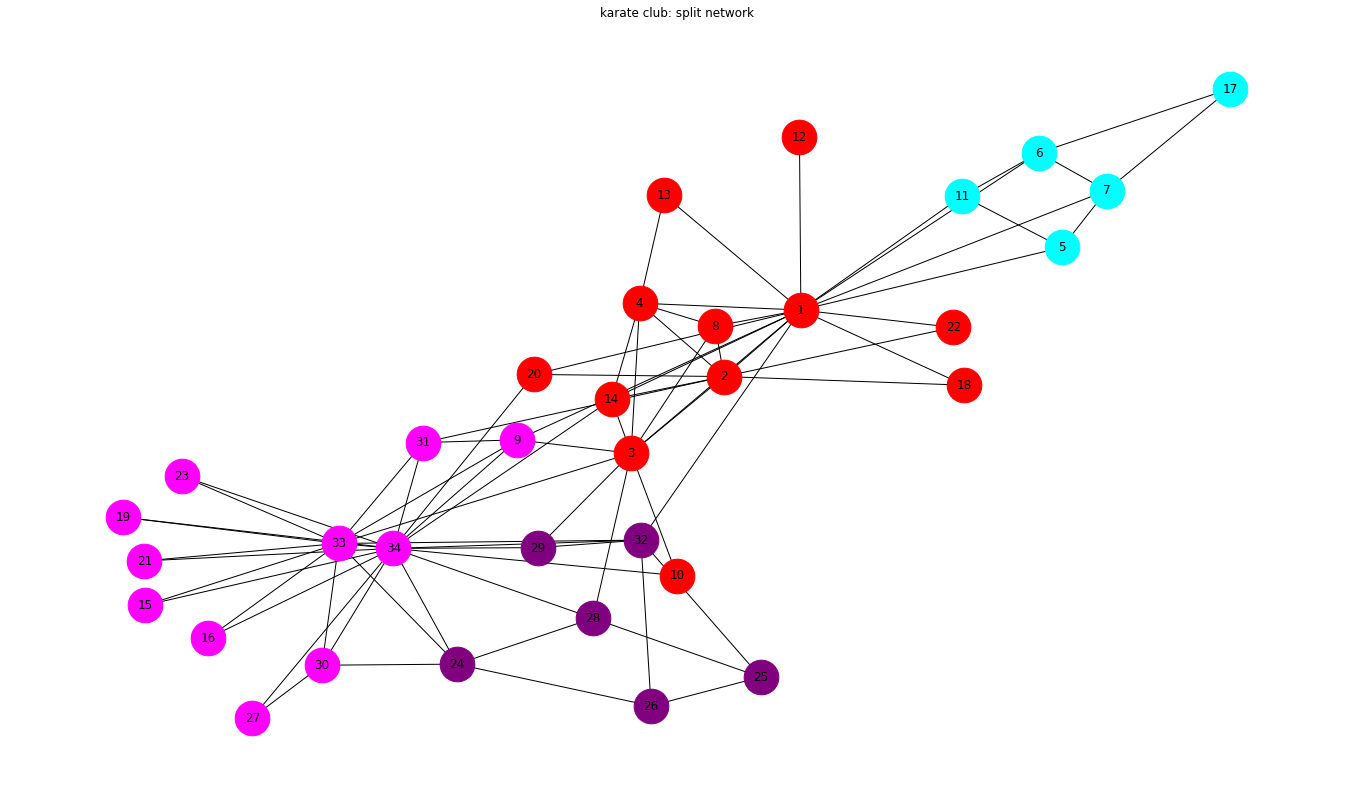

CPU times: user 2.67 s, sys: 184 ms, total: 2.85 s
Wall time: 2.69 s


In [69]:
%%time
import scipy.sparse.linalg
comm_dict = Modularity_clustering(karate_gml)
communities = []
for comm in set(comm_dict.values()):
    communities.append( [node for node in comm_dict if comm_dict[node] == comm])
print("Communities",communities)
colors= ['red', 'cyan','purple','magenta']
pos = nx.spring_layout(karate_gml) 
plt.figure(figsize=(24,14))
nx.draw_networkx_edges (karate_gml, pos=pos) 
for community, color in zip(communities, colors):
  nx.draw_networkx_nodes (karate_gml, pos=pos, nodelist=community, node_color=color, node_size=1200)

nx.draw_networkx_labels(karate_gml, pos=pos) 
_ = plt.axis ('off')

print(get_modularity(karate_gml, comm_dict))
plt.title("karate club: split network")

plt.show()

Communities [['Fork', 'Grin', 'Hook', 'Kringel', 'Scabs', 'Shmuddel', 'SN100', 'SN4', 'SN63', 'SN9', 'Stripes', 'Thumper', 'TR120', 'TR88', 'TR99', 'TSN103', 'TSN83', 'Whitetip', 'Zipfel'], ['CCL', 'Cross', 'Double', 'Five', 'Haecksel', 'Jonah', 'MN105', 'MN60', 'MN83', 'Patchback', 'SMN5', 'Topless', 'Trigger', 'Vau', 'Zap'], ['Beak', 'Bumper', 'Fish', 'Oscar', 'PL', 'SN96', 'TR77'], ['Beescratch', 'DN16', 'DN21', 'DN63', 'Feather', 'Gallatin', 'Jet', 'Knit', 'MN23', 'Mus', 'Notch', 'Number1', 'Quasi', 'Ripplefluke', 'SN89', 'SN90', 'TR82', 'Upbang', 'Wave', 'Web', 'Zig']]
Calculating modularity for undirected graph
0.5264625608164234


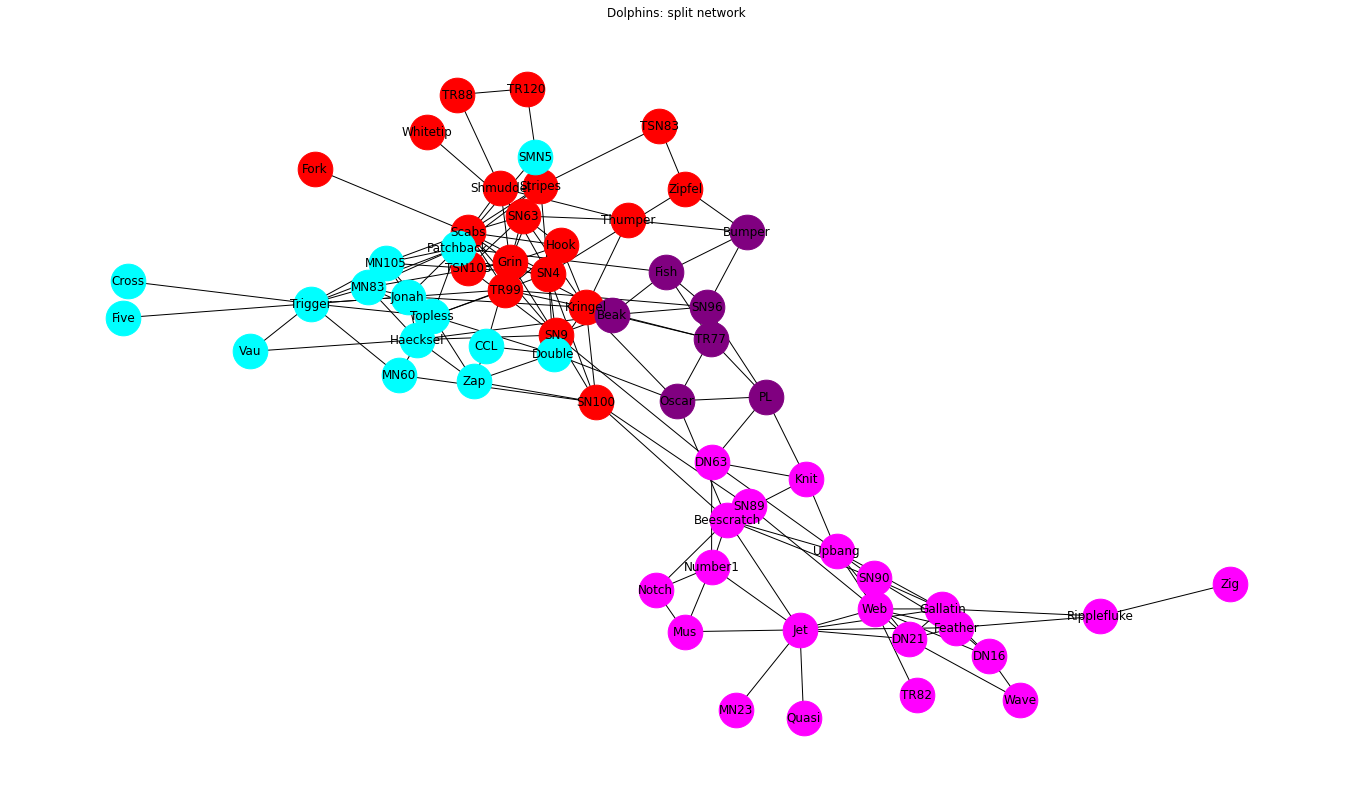

CPU times: user 7.66 s, sys: 327 ms, total: 7.99 s
Wall time: 7.7 s


In [70]:
%%time
comm_dict = Modularity_clustering(dolphins_gml)
communities = []
for comm in set(comm_dict.values()):
    communities.append( [node for node in comm_dict if comm_dict[node] == comm])
print("Communities",communities)
colors= ['red', 'cyan','purple','magenta']
pos = nx.spring_layout(dolphins_gml) 
plt.figure(figsize=(24,14))
nx.draw_networkx_edges (dolphins_gml, pos=pos) 
for community, color in zip(communities, colors):
  nx.draw_networkx_nodes (dolphins_gml, pos=pos, nodelist=community, node_color=color, node_size=1200)

nx.draw_networkx_labels(dolphins_gml, pos=pos) 
_ = plt.axis ('off')

print(get_modularity(dolphins_gml, comm_dict))
plt.title("Dolphins: split network")

plt.show()

Communities [['9', '59', '82', '84', '93', '94', '111', '116', '117', '118', '121', '125', '137', '143', '146', '175', '177', '183', '190', '193'], ['1', '8', '15', '16', '17', '20', '22', '23', '24', '32', '33', '35', '38', '40', '42', '43', '44', '46', '48', '50', '58', '60', '62', '63', '64', '65', '66', '68', '78', '80', '81', '91', '95', '98', '99', '100', '101', '104', '105', '106', '107', '108', '109', '110', '119', '120', '122', '123', '131', '132', '134', '135', '139', '154', '159', '162', '166', '168', '170', '171', '179', '182', '187', '188'], ['2', '7', '10', '11', '12', '14', '19', '30', '31', '34', '36', '49', '52', '53', '54', '55', '56', '57', '61', '67', '69', '70', '71', '72', '74', '83', '87', '89', '103', '112', '113', '114', '127', '129', '130', '141', '142', '150', '151', '158', '161', '164', '165', '174', '178', '185', '186', '192', '194', '195', '196', '197'], ['3', '4', '5', '6', '13', '18', '21', '25', '26', '27', '28', '29', '37', '39', '41', '45', '47', '51'

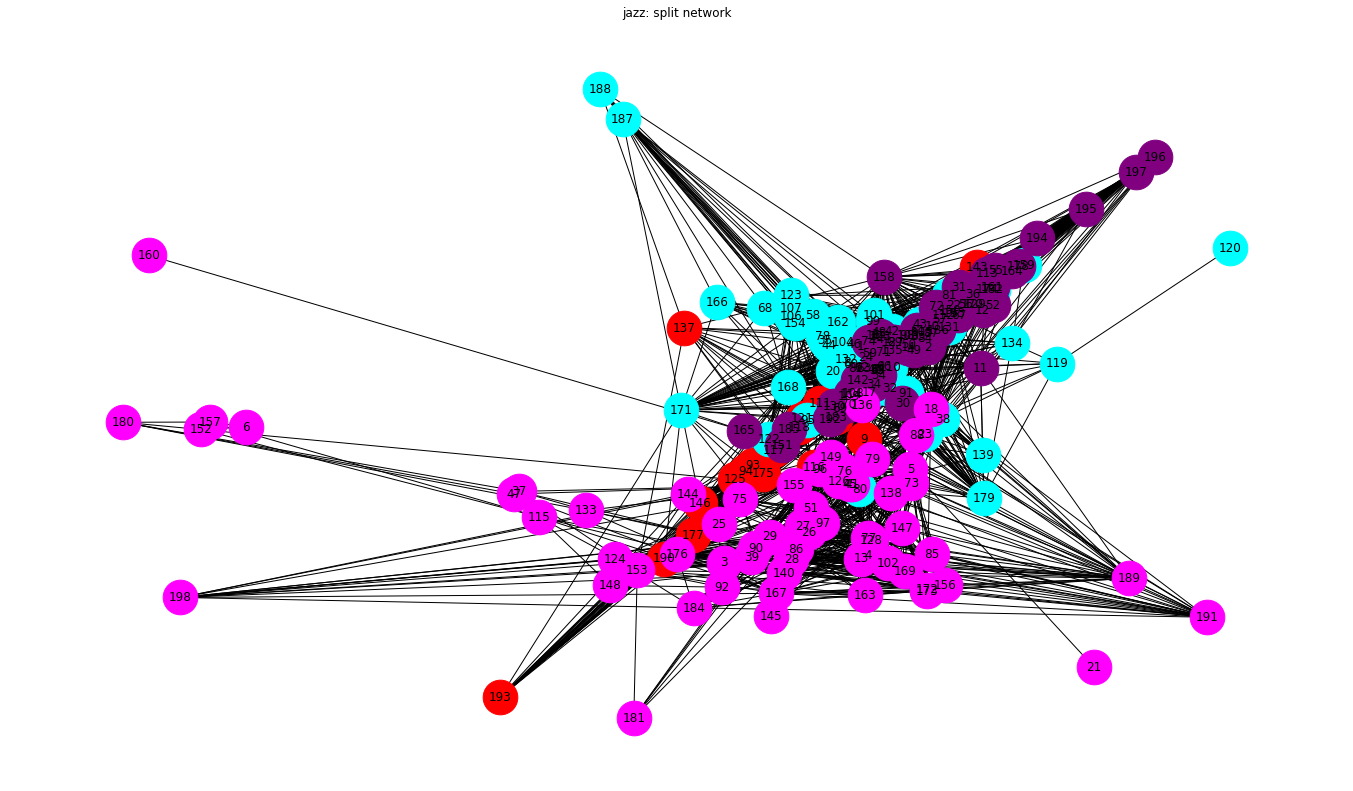

CPU times: user 1min 42s, sys: 1.71 s, total: 1min 43s
Wall time: 1min 42s


In [71]:
%%time
comm_dict = Modularity_clustering(jazz_gml)
communities = []
for comm in set(comm_dict.values()):
    communities.append( [node for node in comm_dict if comm_dict[node] == comm])
print("Communities",communities)
colors= ['red', 'cyan','purple','magenta']
pos = nx.spring_layout(jazz_gml) 
plt.figure(figsize=(24,14))
nx.draw_networkx_edges (jazz_gml, pos=pos) 
for community, color in zip(communities, colors):
  nx.draw_networkx_nodes (jazz_gml, pos=pos, nodelist=community, node_color=color, node_size=1200)

nx.draw_networkx_labels(jazz_gml, pos=pos) 
_ = plt.axis ('off')

print(get_modularity(jazz_gml, comm_dict))
plt.title("jazz: split network")

plt.show()

Node Degree
['1 16', '2 9', '3 10', '4 6', '5 3', '6 4', '7 4', '8 4', '9 5', '10 2', '11 3', '12 1', '13 2', '14 5', '15 2', '16 2', '17 2', '18 2', '19 2', '20 3', '21 2', '22 2', '23 2', '24 5', '25 3', '26 3', '27 2', '28 4', '29 3', '30 4', '31 4', '32 6', '33 12', '34 17']


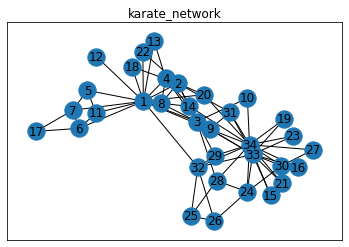

CPU times: user 419 ms, sys: 104 ms, total: 524 ms
Wall time: 416 ms


In [72]:
%%time
def girvan_newman (G):
  G = G.copy ()

  def find_best_edge (G0):
    eb = nx.edge_betweenness_centrality(G0) 
    edges = eb.keys()
    return max(edges, key=lambda e: eb[e])

  removed_edges = []
  while nx.number_connected_components (G) == 1:
    u, v = find_best_edge(G)
    G.remove_edge (u, v)
    removed_edges.append((u, v))

  return list (nx.connected_components(G)), removed_edges

G=nx.karate_club_graph()
G = nx.read_gml("karate.gml", label = 'id')
print("Node Degree")
node_degree = list()
for v in G:
  node_degree.append("%s %s" % (v, G.degree(v))) 
print(node_degree)
nx.draw_networkx(G, with_labels=True)

# plt.savefig("karate_network.png")
plt.title("karate_network")
plt.show()


<class 'list'> [[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21], [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]]


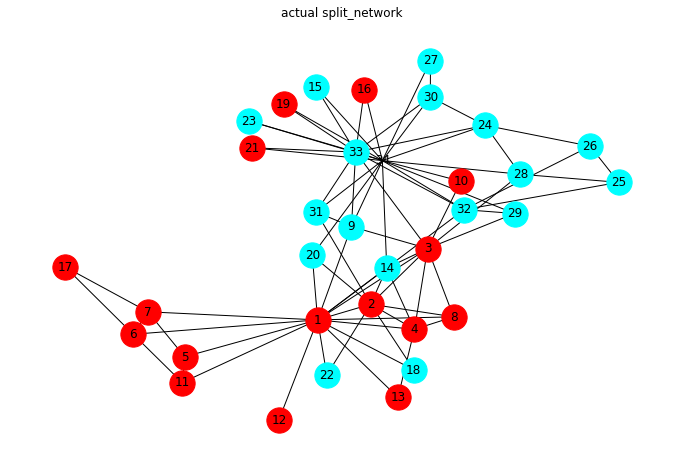

In [ ]:

faction1= [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21]
faction2= [9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

communities = [faction1, faction2]

colors= ['red', 'cyan']

pos = nx.spring_layout(G) 
plt.figure(figsize=(12,8))
nx.draw_networkx_edges (G, pos=pos) 
# print(type(communities),communities)
for community, color in zip(communities, colors):
  nx.draw_networkx_nodes (G, pos=pos, nodelist=community, node_color=color, node_size=640)

nx.draw_networkx_labels(G, pos=pos) 
_ = plt.axis ('off')
# plt. savefig("actual split_network.png")
plt.title("actual split_network")

plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<class 'list'> [{1, 2, 4, 5, 6, 7, 8, 11, 12, 13, 14, 17, 18, 20, 22}, {3, 9, 10, 15, 16, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34}]


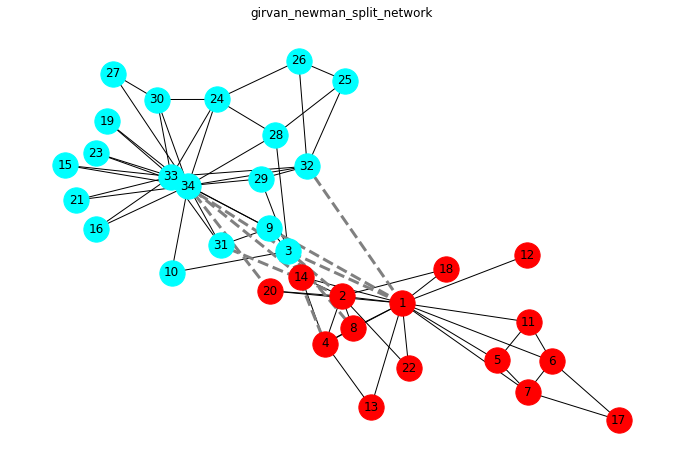

In [ ]:

communities, removed_edges = girvan_newman (G)

other_edges = set(G.edges()) - set(removed_edges)

plt.figure(figsize=(12,8))

nx.draw_networkx_edges (G, pos, edgelist=other_edges)
nx.draw_networkx_edges (G, pos, edgelist=removed_edges, style='dashed', edge_color="gray", width=1) 
print(type(communities),communities)
for community, color in zip(communities, colors):
  nx.draw_networkx_nodes(G, pos=pos, nodelist=community, node_color=color, node_size=640)
nx.draw_networkx_labels(G, pos=pos)
_ = plt.axis('off')
# plt.savefig("girvan_newman_split_network.png")
plt.title("girvan_newman_split_network")
plt.show()

In [ ]:
!pip install python-modularity-maximization==0.0.1rc4